This Notebook/demo uses spike interface, [here is how to install Spike Interface](https://spikeinterface.readthedocs.io/en/latest/installation.html)

In [20]:
import sys
from pathlib import Path

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import UnitMatchPy.extract_raw_data as erd
import numpy as np 
import probeinterface as pi
import spikeinterface.exporters as sex
from spikeinterface.preprocessing import (bandpass_filter,
                                           common_reference,
                                           whiten)
from spikeinterface.extractors.neoextractors.openephys import OpenEphysBinaryRecordingExtractor
import os
import glob

In [21]:
def load_filen(animal,day,ephys_path):
    raw_path = []
    phy_folder = []
    pattern = rf'{ephys_path}\{animal}\{animal}_{day}*A'
    raw_path.append(glob.glob(pattern))
    pattern = rf'{ephys_path}\{animal}\{animal}_{day}*B'
    raw_path.append(glob.glob(pattern))
    pattern = rf'{ephys_path}\{animal}\{animal}_{day}*C'
    raw_path.append(glob.glob(pattern))
    pattern = rf'{ephys_path}\{animal}\{animal}_{day}*A*4match'
    phy_folder.append(glob.glob(pattern))
    pattern = rf'{ephys_path}\{animal}\{animal}_{day}*B*4match'
    phy_folder.append(glob.glob(pattern))
    pattern = rf'{ephys_path}\{animal}\{animal}_{day}*C*4match'
    phy_folder.append(glob.glob(pattern))
    return raw_path, phy_folder

## Load Data & get good units

Spike Interface can load in many different types of Ephys data look [here](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html) for documentation on fucntion to read in different data formats. 

In [22]:
#sachuriga example

animal = '63383'
day = '2024-07-28'
ephys_path = 'S:\Sachuriga\Ephys_Recording\CR_CA1'
raw_path, phy_folder=load_filen(animal,day,ephys_path)
Recordings=[]

for rp in raw_path:

    stream_name  = OpenEphysBinaryRecordingExtractor(rp[0],stream_id='0').get_streams(rp[0])[0][0]
    print(fr"Merging step_Before mannual search the stream_name. Auto search result is {stream_name}")
    record_node = stream_name.split("#")[0]
    aquisition_sys = stream_name.split("#")[1]
    recording= se.read_openephys(Path(rp[0]), stream_name=stream_name, load_sync_timestamps=True)

        
    manufacturer = 'cambridgeneurotech'
    probe_name = 'ASSY-236-F'
    probe = pi.get_probe(manufacturer, probe_name)
    print(probe)
    # probe.wiring_to_device('cambridgeneurotech_mini-amp-64')
    # map channels to device indices
    mapping_to_device = [
        # connector J2 TOP
        41, 39, 38, 37, 35, 34, 33, 32, 29, 30, 28, 26, 25, 24, 22, 20,
        46, 45, 44, 43, 42, 40, 36, 31, 27, 23, 21, 18, 19, 17, 16, 14,
        # connector J1 BOTTOM
        55, 53, 54, 52, 51, 50, 49, 48, 47, 15, 13, 12, 11, 9, 10, 8,
        63, 62, 61, 60, 59, 58, 57, 56, 7, 6, 5, 4, 3, 2, 1, 0
    ]
    probe.set_device_channel_indices(mapping_to_device)
    probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]
    probegroup = pi.ProbeGroup()
    probegroup.add_probe(probe)
    pi.write_prb(f"{probe_name}.prb", probegroup, group_mode="by_shank")
    recording_prb = recording.set_probe(probe, group_mode="by_shank")
    Recordings.append(recording_prb)
    
Sortings = [se.read_phy(Path(file[0])) for file in phy_folder]

#Will only make average wavefroms for good units
ExtractGoodUnitsOnly = False

Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 102#OE_FPGA_Acquisition_Board-101.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm Data
ASSY-236-F - cambridgeneurotech - 64ch - 6shanks


In [23]:
#Getting good units only
Sortings[0].get_property_keys() #lists keys for attached propties if 'quality' is not suitbale
#Good units which will be used in Unit Match
GoodUnits = []
UnitsUsed = []
ids = np.empty(len(Sortings), dtype=object) 
for i, sorting in enumerate(Sortings):
    UnitIdsTmp = sorting.get_property('original_cluster_id')
    IsGoodTmp = sorting.get_property('quality').astype(dtype='<U50')
    GoodUnits.append(np.stack((UnitIdsTmp,IsGoodTmp), axis = 1))

    UnitsUsed.append(UnitIdsTmp)
    if ExtractGoodUnitsOnly is True:
       # keep = np.argwhere(IsGoodTmp == 'good').squeeze()
        keep = np.argwhere((IsGoodTmp == 'good')).squeeze()
        idss = sorting.get_unit_ids()
        id = idss[keep]
        Sortings[i] = sorting.select_units(id)
        
        ids[i]=id.tolist()
        #ids[i] = Sortings[0].get_property('original_cluster_id')
    else:
               # keep = np.argwhere(IsGoodTmp == 'good').squeeze()
        keep = np.argwhere((IsGoodTmp == 'good') | (IsGoodTmp == 'mua')).squeeze()
        idss = sorting.get_unit_ids()
        id = idss[keep]
        Sortings[i] = sorting.select_units(id)
        
        ids[i]=id.tolist()
        #ids[i] = Sortings[0].get_property('original_cluster_id')

## Process average waveforms / templates

Beaware the spike interface method is different to the native unitmatch method in ExtractRawDemo.ipynb or in the MatLab version

In [24]:
# # Preprocces the raw data
for recording in Recordings:
    #recording = spre.phase_shift(recording, inter_sample_shift=None) #correct for time delay between recording channels
    bad_channel_ids, channel_labels = spre.detect_bad_channels(recording, method="coherence+psd")
    # remove bad channels
    recording = recording.remove_channels(bad_channel_ids)
    recording  = spre.bandpass_filter(recording, freq_min=300, freq_max=6000) #highpass
    recording = spre.common_reference(recording=recording, operator="median", reference="global")
    recording = whiten(recording, int_scale=200, mode='local', radius_um=100.0)
    # for motion correction, this can be very slow
    #Uncommented code below to do in session motion correction
    #recording = spre.correct_motion(recording, preset="nonrigid_fast_and_accurate")

for sorting in Sortings:
    #recording = spre.phase_shift(recording, inter_sample_shift=None) #correct for time delay between recording channels
    sorting.set_property(key='group', values = sorting.get_property("channel_group")) #highpass

In [25]:
#Split each recording/sorting into 2 halves                    
for i, sorting in enumerate(Sortings):
    SplitIdx = Recordings[i].get_num_samples() // 2

    SplitSorting = []
    SplitSorting.append(sorting.frame_slice(start_frame=0, end_frame=SplitIdx))
    SplitSorting.append(sorting.frame_slice(start_frame=SplitIdx, end_frame=Recordings[i].get_num_samples()))

    Sortings[i] = SplitSorting 

for i, recording in enumerate(Recordings):
    SplitIdx = recording.get_num_samples() // 2

    SplitRecording = []
    SplitRecording.append(recording.frame_slice(start_frame=0, end_frame=SplitIdx))
    SplitRecording.append(recording.frame_slice(start_frame=SplitIdx, end_frame=recording.get_num_samples()))

    Recordings[i] = SplitRecording

In [26]:
#create sorting analyzer for each pair
Analysers = []
for i in range(len(Recordings)):
    SplitAnalysers = []
    SplitAnalysers.append(si.create_sorting_analyzer(Sortings[i][0], Recordings[i][0], sparse=False))
    SplitAnalysers.append(si.create_sorting_analyzer(Sortings[i][1], Recordings[i][1], sparse=False))
    Analysers.append(SplitAnalysers)

In [27]:
#create the fast tempalte extension for each sorting analyser
AllWaveforms = []
for i in range(len(Analysers)):
    for half in range(2):
        Analysers[i][half].compute(
            "random_spikes","waveforms",
            method="uniform",
            max_spikes_per_unit=1000)
        Analysers[i][half].compute("noise_levels")
        Analysers[i][half].compute("templates")
        #Analysers[i][half].compute('fast_templates', n_jobs = 0.8,  return_scaled=True)
        #Analysers[i][half].compute('fast_templates', n_jobs = 0.8)
    TemplatesFirst = Analysers[i][0].get_extension('templates')
    TemplatesSecond = Analysers[i][1].get_extension('templates')
    t1 = TemplatesFirst.get_data()
    t2 = TemplatesSecond.get_data()
    AllWaveforms.append(np.stack((t1,t2), axis = -1))

#Make a channel_postions array
AllPositions = []
for i in range(len(Analysers)):
    #postions for first half and second half are the same
    AllPositions.append(Analysers[i][0].get_channel_locations())

noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.20it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 642/642 [00:49<00:00, 12.96it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.55it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 642/642 [00:48<00:00, 13.32it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.32it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 607/607 [00:50<00:00, 12.12it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:03<00:00,  6.53it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 607/607 [00:47<00:00, 12.81it/s]
noise_level (no parallelization): 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]
estimate_templates_with_accumulator (no parallelization): 100%|██████████| 608/608 [00:42<00:00, 14.24it/s]
noise_level (no parallelization): 100%|██████████|

## Save extracted data in a unit match friendly folder

In [28]:
import os
import shutil
#UMInputDir = os.path.join(os.getcwd(), 'UMInputData')
UMInputDir = rf'{ephys_path}\{animal}\{animal}_{day}_UMInputData'

if os.path.exists(UMInputDir):
    shutil.rmtree(UMInputDir)
os.mkdir(UMInputDir)
AllSessionPaths = []
for i in range(len(Recordings)):
    SessionXpath = os.path.join(UMInputDir, f'Session{i+1}') #lets start at 1
    os.mkdir(SessionXpath)

    #save the GoodUnits as a .rsv first column is unit ID,second is 'good' or 'mua'
    GoodUnitsPath = os.path.join(SessionXpath, 'cluster_group.tsv')
    ChannelPositionsPath = os.path.join(SessionXpath, 'channel_positions.npy')
    SaveGoodUnits = np.vstack((np.array(('cluster_id', 'group')), GoodUnits[i])) #Title of colum one is '0000' Not 'cluster_id')
    #SaveGoodUnits[0,0] = 0 # need to be int to use np.savetxt 
    np.savetxt(GoodUnitsPath, SaveGoodUnits, fmt =['%s','%s'], delimiter='\t')
    
    if ExtractGoodUnitsOnly:        
        ids = GoodUnits[i][:,0].tolist()  # Assuming this converts ids to a list
        good = GoodUnits[i][:,1].tolist()  # Assuming this converts good to a list
        temp = [g == 'good' for g in good]  # Creates a boolean list where 'good' is found
        filtered_ids = [[id] for id, t in zip(ids, temp) if t]
        filtered_ids 
        #Units = np.argwhere(GoodUnits[0][:,1] == 'good')
        erd.save_avg_waveforms(AllWaveforms[i], SessionXpath, filtered_ids)
    else:
        erd.save_avg_waveforms(AllWaveforms[i], SessionXpath, np.int64(GoodUnits[i][:,0]))
    np.save(ChannelPositionsPath, AllPositions[i])
    AllSessionPaths.append(SessionXpath)

Saved 39 units to RawWaveforms directory, saving all units
Saved 43 units to RawWaveforms directory, saving all units
Saved 54 units to RawWaveforms directory, saving all units


## Run UnitMatch

In [29]:
%reload_ext autoreload
%autoreload 
import UnitMatchPy.bayes_functions as bf
import UnitMatchPy.utils as util
import UnitMatchPy.overlord as Overlord
import numpy as np
import matplotlib.pyplot as plt
import UnitMatchPy.GUI as gui
import UnitMatchPy.save_utils as su
import UnitMatchPy.default_params as default_params
import UnitMatchPy.assign_unique_id as aid
import UnitMatchPy

In [30]:
#get default parameters, can add your own before or after!
# default of Spikeinterface as by default spike interface extracts waveforms in a different manner.
param = {'SpikeWidth': 90, 'waveidx': np.arange(20,50), 'PeakLoc': 35}
param = default_params.get_default_param(param)
param['no_shanks']=6
param['shank_dist']=125
wave_paths, unit_label_paths, channel_pos = util.paths_from_KS(AllSessionPaths)

Using cluster_group.tsv
Using cluster_group.tsv
Using cluster_group.tsv


In [31]:
def zero_center_waveform(waveform):
    """
    Centers waveform about zero, by subtracting the mean of the first 15 time points.
    This function is useful for Spike Interface where the waveforms are not centered about 0.

    Arguments:
        waveform - ndarray (nUnits, Time Points, Channels, CV)

    Returns:
        Zero centered waveform
    """
    waveform = waveform -  np.broadcast_to(waveform[:,:15,:,:].mean(axis=1)[:, np.newaxis,:,:], waveform.shape)
    return waveform

In [32]:
#read in data and select the good units and exact metadata
#waveform, SessionID, SessionSwitch, WithinSession, GoodUnits, param = util.load_good_waveforms(WavePaths, UnitLabelPaths, param) # 1-step version of above
#read in data and select the good units and exact metadata

waveform, session_id, session_switch, within_session, good_units, param = util.load_good_waveforms(wave_paths, unit_label_paths,  param, good_units_only =False) 

#Recenter the waveform at 0, as is not part of spike interface tempaltes 
waveform = zero_center_waveform(waveform)

# create clusInfo, contains all unit id/session related info
clus_info = {'good_units' : GoodUnits, 'session_switch' : session_switch, 'session_id' : session_id, 
            'original_ids' : np.concatenate(GoodUnits) }

UnitMatch is treating all the units as good and including all units from S:\Sachuriga\Ephys_Recording\CR_CA1\63383\63383_2024-07-28_UMInputData\Session1\RawWaveforms, we recommended using curated data!
UnitMatch is treating all the units as good and including all units from S:\Sachuriga\Ephys_Recording\CR_CA1\63383\63383_2024-07-28_UMInputData\Session2\RawWaveforms, we recommended using curated data!
UnitMatch is treating all the units as good and including all units from S:\Sachuriga\Ephys_Recording\CR_CA1\63383\63383_2024-07-28_UMInputData\Session3\RawWaveforms, we recommended using curated data!


In [33]:
extracted_wave_properties = Overlord.extract_parameters(waveform, channel_pos, clus_info, param)

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:231: RuntimeWarning: invalid value encountered in divide
  mu = np.sum( np.tile(spatial_fp[:], (1,3)) * loc, axis = 0) / np.sum(spatial_fp[:])
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\param_functions.py:322: RuntimeWarning: All-NaN slice encountered
  tmp_peak = np.nanmax(avg_waveform[:,i,cv])


This unit 92, CV 1 is very likely a bad unit!
unit92 is very likely bad, no good time points in average waveform


In [34]:
#Extract metric scores
total_score, candidate_pairs, scores_to_include, predictors = Overlord.extract_metric_scores(extracted_wave_properties, session_switch, within_session, param, niter  = 2)

#Probability analysis
priorMatch = 1 - (param['n_expected_matches'] / param['n_units']**2 ) # fredom of choose in prior prob?
Priors = np.array((priorMatch, 1-priorMatch))

labels = candidate_pairs.astype(int)
Cond = np.unique(labels)
ScoreVector = param['score_vector']
parameter_kernels = np.full((len(ScoreVector), len(scores_to_include), len(Cond)), np.nan)
parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, Cond, param, add_one = 1)
probability = bf.apply_naive_bayes(parameter_kernels, Priors, predictors, param, Cond)
output_prob_matrix = probability[:,1].reshape(param['n_units'],param['n_units'])

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:111: RuntimeWarning: All-NaN slice encountered
  projected_waveform_norm =  (projected_waveform_norm - np.nanmin(projected_waveform_norm,axis = 0)) / (np.nanmax(projected_waveform_norm, axis=0) - np.nanmin(projected_waveform_norm, axis = 0))
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:115: RuntimeWarning: Mean of empty slice
  raw_wave_mse = np.nanmean( (x1 - x2)**2, axis = 0 ).squeeze()
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:147: RuntimeWarning: All-NaN slice encountered
  new_vals = np.nanmin(tmpdat, axis =1, keepdims=True) + np.nanmax(tmpdat, axis = 1, keepdims=True) - tmpdat
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\UnitMatchPy\metric_functions.py:211: RuntimeWarning: All-NaN slice encountered
  centroid_dist = np.nanmin( euclid_dist[:,new

Session pair 1/2 has [9 3 2 6] matches per shank, which is below threshold to do per shank drift correction
Session pair 2/3 has [8 1 2 6] matches per shank, which is below threshold to do per shank drift correction
Calculating the probability distributions of the metric scores
Calculating the match probabilities


The percentage of units matched to themselves is: 66.9172932330827%
The percentage of false -ve's then is: 33.0827067669173% 

The rate of miss-match(es) per expected match 0.7142857142857143
The percentage of false +ve's is 2.844950213371266% for session 1
The percentage of false +ve's is 1.684088269454123% for session 2
The percentage of false +ve's is 0.9433962264150944% for session 3

This assumes that the spike sorter has made no mistakes


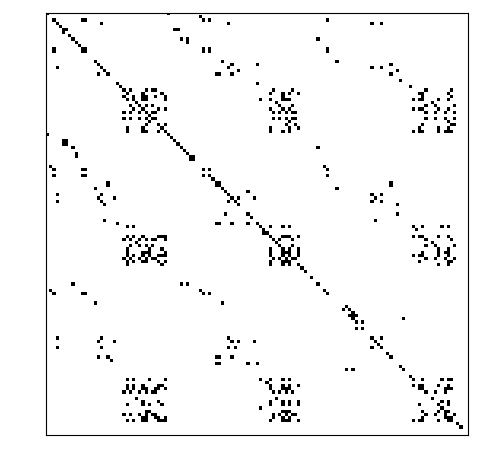

In [35]:
util.evaluate_output(output_prob_matrix, param, within_session, session_switch, match_threshold = 0.75)
match_threshold = param['match_threshold']
OutputThreshold = np.zeros_like(output_prob_matrix)
OutputThreshold[output_prob_matrix > match_threshold] = 1
plt.imshow(OutputThreshold, cmap = 'Greys')

In [36]:
amplitude = extracted_wave_properties['amplitude']
spatial_decay = extracted_wave_properties['spatial_decay']
avg_centroid = extracted_wave_properties['avg_centroid']
avg_waveform = extracted_wave_properties['avg_waveform']
avg_waveform_per_tp = extracted_wave_properties['avg_waveform_per_tp']
wave_idx = extracted_wave_properties['good_wave_idxs']
max_site = extracted_wave_properties['max_site']
max_site_mean = extracted_wave_properties['max_site_mean']
gui.process_info_for_GUI(output_prob_matrix, match_threshold, scores_to_include, total_score, amplitude, spatial_decay,
                         avg_centroid, avg_waveform, avg_waveform_per_tp, wave_idx, max_site, max_site_mean, 
                         waveform, within_session, channel_pos, clus_info, param)

In [18]:
is_match, not_match, matches_GUI = gui.run_GUI()

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
matches_curated = util.curate_matches(matches_GUI, is_match, not_match, mode = 'And')

In [37]:
matches = np.argwhere(match_threshold == 0.99)
UIDs = aid.assign_unique_id(output_prob_matrix, param, clus_info)

SaveDir = rf'{ephys_path}\{animal}\{animal}_{day}_unitmatchResults'
su.save_to_output(SaveDir, scores_to_include, matches, output_prob_matrix, avg_centroid, avg_waveform, avg_waveform_per_tp, max_site,
                   total_score, OutputThreshold,  clus_info, param, UIDs=UIDs,matches_curated = True, save_match_table = True)

Number of Liberal Matches: 156
Number of Intermediate Matches: 94
Number of Conservative Matches: 86


In [ ]:
import pandas as pd
ephys_path = 'S:\Sachuriga\Ephys_Recording\CR_CA1'

df = pd.read_csv(rf'{ephys_path}\{animal}\{animal}_{day}_unitmatchResults\MatchTable.csv')

In [ ]:
df1 = df[df['Matches']==1]
df2=df1[df1['RecSes 2']==1]
df2

,ID1,ID2,RecSes 1,RecSes 2,Matches,UM Probabilities,TotalScore,amp_score,spatial_decay_score,centroid_overlord_score,...,waveform_score,trajectory_score,UID1,UID2,UID Liberal 1,UID Liberal 2,UID int 1,UM UID int 2,UID Conservative 1,UID Conservative 2
8,8,0,1,1,1,0.559306,0.647287,0.608143,0.477241,0.786212,...,0.524703,0.705955,8,0,8,0,8,0,8,0
9,9,0,1,1,1,0.593231,0.572245,0.759985,0.668933,0.780498,...,0.716107,0.808139,9,0,9,0,9,0,9,0
13,13,0,1,1,1,0.559860,0.572686,0.524698,0.612198,0.838065,...,0.942391,0.818306,13,0,9,0,13,0,13,0
22,0,0,2,1,1,0.709685,0.658443,0.769625,0.625613,0.668425,...,0.472092,0.637037,22,0,8,0,8,0,8,0
41,19,0,2,1,1,0.913726,0.699042,0.353980,0.632082,0.662658,...,0.877444,0.795453,41,0,0,0,41,0,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,17,17,1,1,1,0.933529,0.746816,0.513099,0.734521,0.870367,...,0.741050,0.692176,17,17,17,17,17,17,17,17
1173,17,18,2,1,1,0.715759,0.680894,0.637730,0.582328,0.852550,...,0.530898,0.629360,39,18,39,18,39,18,39,18
1216,19,19,1,1,1,0.987612,0.848461,0.833453,0.640790,0.904606,...,0.831356,0.803380,19,19,19,19,19,19,19,19
1280,20,20,1,1,1,0.942852,0.777733,0.512300,0.538741,0.965920,...,0.882581,0.767136,20,20,20,20,20,20,20,20


: 

In [ ]:
xx, yy = np.meshgrid(original_ids, original_ids)
unit_a_list = xx.reshape(n_units*n_units)
unit_b_list = yy.reshape(n_units*n_units)


In [ ]:
np.meshgrid(original_ids, original_ids)

[array([['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ...,
        ['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ['0', 'mua', '1', ..., 'mua', '19', 'mua'],
        ['0', 'mua', '1', ..., 'mua', '19', 'mua']], dtype='<U50'),
 array([['0', '0', '0', ..., '0', '0', '0'],
        ['mua', 'mua', 'mua', ..., 'mua', 'mua', 'mua'],
        ['1', '1', '1', ..., '1', '1', '1'],
        ...,
        ['mua', 'mua', 'mua', ..., 'mua', 'mua', 'mua'],
        ['19', '19', '19', ..., '19', '19', '19'],
        ['mua', 'mua', 'mua', ..., 'mua', 'mua', 'mua']], dtype='<U50')]

In [ ]:
import pandas as pd
ephys_path = 'S:\Sachuriga\Ephys_Recording\CR_CA1'

df = pd.read_csv(rf'{ephys_path}\{animal}\{animal}_{day}_unitmatchResults\MatchTable.csv')

In [ ]:
df1 = df[df['Matches']==1]
df2=df1[df1['RecSes 2']==1]
df

,ID1,ID2,RecSes 1,RecSes 2,Matches,UM Probabilities,TotalScore,AmpScore,SpatialDecayScore,CentroidOverlord,CentroidDist,WaveformScore,TrajectoryScore
0,6,6,1,1,1,0.999981,0.896175,0.601483,0.762703,0.976545,0.980322,0.979726,0.874412
1,7,6,1,1,0,0.002614,0.681720,0.753830,0.520181,0.843550,0.851751,0.693527,0.526268
2,9,6,1,1,0,0.000090,0.397127,0.760701,0.570237,0.836600,0.000000,0.322726,0.390256
3,10,6,1,1,0,0.000107,0.333470,0.562141,0.533055,0.745555,0.000000,0.458230,0.288840
4,11,6,1,1,0,0.000012,0.315856,0.604460,0.354040,0.838837,0.000000,0.341712,0.367779
...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,4,9,3,3,0,0.000004,0.199958,0.156988,0.139472,0.532109,0.000000,0.809808,0.335541
621,5,9,3,3,0,0.000002,0.159651,0.199129,0.019742,0.682884,0.000000,0.382431,0.504397
622,6,9,3,3,0,0.000002,0.106621,0.023560,0.034076,0.725807,0.000000,0.302507,0.458798
623,7,9,3,3,0,0.000017,0.204853,0.364767,0.023311,0.183797,0.657460,0.286014,0.481078


In [ ]:
rf'{ephys_path}\{animal}\{animal}_{day}_unitmatchResults\MatchTable.csv'

'S:\\Sachuriga\\Ephys_Recording\\CR_CA1\\65588\\65588_2024-03-12_unitmatchResults\\MatchTable.csv'